In [7]:
!poetry add llama_index ftfy regex tqdm
!poetry add git+https://github.com/openai/CLIP.git
!poetry add torch torchvision
!poetry add matplotlib scikit-image
!poetry add pymilvus

The following packages are already present in the pyproject.toml and will be skipped:

  - llama_index
  - ftfy
  - regex
  - tqdm

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.

Updating dependencies
Resolving dependencies... (1.0s)

No dependencies to install or update
The following packages are already present in the pyproject.toml and will be skipped:

  - torch
  - torchvision

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - matplotlib
  - scikit-image

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer 

In [8]:
!poetry add llama-index-llms-ollama

The following packages are already present in the pyproject.toml and will be skipped:

  - llama-index-llms-ollama

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [9]:
from pathlib import Path
import requests

wiki_titles = [
    "Kathmandu",
    "Helsinki",
    "iPhone",
    "Tesla Model S"
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [10]:
from dotenv import load_dotenv

load_dotenv()

True

In [11]:
!poetry add transformers
!poetry add llama-index-vector-stores-milvus
!poetry add llama-index-embeddings-huggingface

The following packages are already present in the pyproject.toml and will be skipped:

  - transformers

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - llama-index-vector-stores-milvus

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - llama-index-embeddings-huggingface

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add

In [12]:
!poetry add 'pymilvus['model']==2.4.*'


Updating dependencies
Resolving dependencies... (0.8s)

No dependencies to install or update


In [13]:
from pymilvus import MilvusClient

from llama_index.core import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.llms.ollama import Ollama


text_client = MilvusClient()

# load Text documents from the data_wiki directory
text_documents = SimpleDirectoryReader("./data_wiki").load_data()

# define LLM and embedding model in ServiceContext
service_context = ServiceContext.from_defaults(
    llm=Ollama(model="llama3", request_timeout=120.0, temperature=0.1),
    embed_model="local:BAAI/bge-base-en-v1.5"
)

# create MilvusVectorStore using MilvusClient and the collection name "widipedia_text"
text_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_text", dim=768, overwrite=True
)

# create StorageContext object using the MilvusVectorStore
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

# create VectorStoreIndex using the text documents and StorageContext
wiki_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context,
    service_context=service_context
)

# define the text query engine
text_query_engine = wiki_text_index.as_query_engine()

/var/folders/kv/3dw9p_ts4b114chqt9m027pc0000gn/T/ipykernel_16304/1116781744.py:19: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


In [14]:
len(text_documents)

4

In [15]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [16]:
!poetry add wikipedia

The following packages are already present in the pyproject.toml and will be skipped:

  - wikipedia

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [17]:
import wikipedia
import urllib.request

image_path = Path("images_wiki")
image_uuid = 0

# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = [
    "Kathmandu",
    "Helsinki",
    "iPhone",
    "Tesla Model S"
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        # raise Exception("No page found")
        continue

Kathmandu
Helsinki
iPhone
Tesla Model S


/Users/stephen/Library/Caches/pypoetry/virtualenvs/multimodal-milvus-clip-SwowcNo4-py3.11/lib/python3.11/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


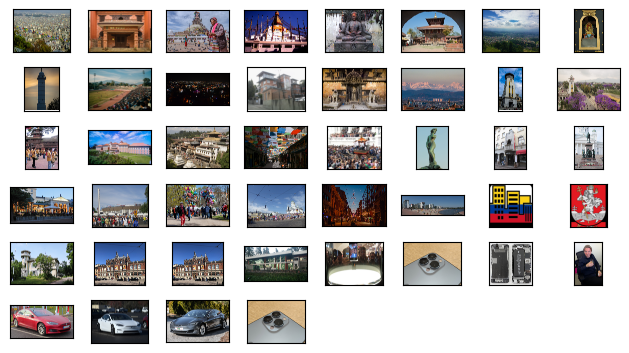

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

In [19]:
# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [20]:
len(img_emb_dict)

44

In [21]:
from llama_index.core.schema import ImageDocument

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        #print(filepath)

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create MilvusVectorStore, with collection name "wikipedia_img"
image_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_img", dim=512, overwrite=True
)

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context
)

In [22]:
from llama_index.core.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """ take a text query as input and return the most similar image from the vector store """

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # returns 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results


In [23]:
def plot_image_retrieve_results(image_retrieval_results):
    """ take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [24]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)
    

Text retrieval results: 
The original iPhone has been described as "revolutionary" and "breakthrough handheld computer", and it is now Apple's bestselling product. It was credited with helping to make Apple one of the world's most valuable publicly traded companies by 2011. Newer iterations have also received praise and awards. The iPhone has been adopted by both consumers and business users, and its premium positioning has led it to capture nearly half of global smartphone revenue, and 80% of global smartphone profits.


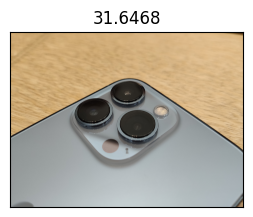

In [25]:
# https://en.wikipedia.org/wiki/iPhone
query1 = "Can you tell me more about the iPhone?"
# generate image retrieval results
image_query(query1)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Some popular tourist attractions in Helsinki include the Suomenlinna fortress, Korkeasaari Zoo, and the city's many nature reserves and parks. The city also has a rich cultural scene, with numerous museums, galleries, and performance venues to explore. Additionally, Helsinki's historic Old Market Hall and Market Square are popular destinations for foodies and shoppers alike.


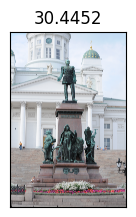

In [26]:
# https://en.wikipedia.org/wiki/Helsinki
query2 = "What are some of the popular tourist attraction in Helsinki?"
# generate image retrieval results
image_query(query2)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))